### 1. Imports

#### 1.1 Overview

This section is where the required libraries and modules are imported

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import torch
from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.svm import SVR

### 2. Data reading and preview

#### 2.1 Overview

This section involves loading and checking the data ahead of modeling

In [2]:
catalonia_analysis_df = pd.read_parquet("../datasets/processed/catalonia_analysis_df.parquet", engine='fastparquet')

In [3]:
catalonia_analysis_df.head() 

,metres_cadastre,energia_primaria_no_renovable,rehabilitacio_energetica,emissions_co2,consum_energia_final,cost_anual_energia_habitatge,any_construccio_lri,valor_aïllaments,valor_finestres,valor_finestres_cte,...,latitud,longitud,poblacio,comarca,nom_provincia,any_entrada,data_entrada,any_construccio_mbi_dt,any_construccio_lri_dt,cost_m2
index,,,,,,,,,,,,,,,,,,,,,
0,55.0,261.50,NO,50.33,180.63,16.90,1978.053589,0.73,3.78,2.1,...,41.443798,2.138852,Escala (L'),Alt Empordà,Girona,2024,2024-02-19,1977-01-01,1978-01-01,0.307273
1,116.0,289.13,NO,75.53,242.61,18.39,1993.678101,2.94,5.00,2.1,...,41.443798,2.138852,Vilamacolum,Alt Empordà,Girona,2020,2020-08-05,2002-01-01,1993-01-01,0.158534
2,122.0,260.98,NO,44.21,133.56,21.18,1979.498291,1.19,3.66,2.1,...,41.443798,2.138852,Alforja,Baix Camp,Tarragona,2022,2022-05-23,2003-01-01,1979-01-01,0.173607
3,104.0,28.12,NO,4.76,14.39,2.28,2005.651367,0.43,2.88,2.1,...,41.443798,2.138852,Alforja,Baix Camp,Tarragona,2022,2022-11-14,2003-01-01,2005-01-01,0.021923
4,1730.0,24.76,NO,4.24,61.51,8.77,1986.248291,0.30,2.04,2.1,...,41.443798,2.138852,Vilamalla,Alt Empordà,Girona,2023,2023-07-27,1985-01-01,1986-01-01,0.005069


In [4]:
catalonia_analysis_df.isnull().mean().sum()

np.float64(7.521969793273704e-07)

In [5]:
def optimize_dataframe_memory(df):
    df = df.copy()
    print(f"Original memory usage: {df.memory_usage().sum() / 1024 ** 2:.2f} MB")
    
    # Downcasting integers
    int_cols = df.select_dtypes(include=['int64', 'int32']).columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    
    # Downcasting floats
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    
    # Converting object columns to category if there are fewer unique values than 50% of total rows
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        num_unique_values = df[col].nunique()
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            df[col] = df[col].astype('category')
    
    print(f"Optimized memory usage: {df.memory_usage().sum() / 1024 ** 2:.2f} MB")
    return df

def display_dataframe_info(df):
    # Print the shape of the dataframe
    print('Shape:', df.shape)
    
    # Print the column names with their data types
    dtypes_list = [f"{col}:{dtype}" for col, dtype in zip(df.columns, df.dtypes)]
    print('Dtypes:', dtypes_list)
    
    # Print the column names with the percentage of missing values
    missings_list = [f"{col}:{missing:.2f}%" for col, missing in zip(df.columns, df.isnull().mean()*100)]
    print('Missings (%):', missings_list)
    
    # Calculate total missing percentage
    total_missing_percentage = (df.isnull().sum().sum() / df.size) * 100
    print(f'Total missings (%): {total_missing_percentage:.2f}%')

    
    # Print total duplicates
    print('total duplicates:', df.duplicated(keep=False).sum())
    
    # Print the total memory consumed by the dataframe
    memory_usage = df.memory_usage().sum() / 1024**2  # Convert bytes to megabytes (MB)
    print(f"Total memory usage: {memory_usage:.2f} MB")
    
    # Display the first 2 rows of the dataframe
    return df.head(2)



### 3. Modeling

#### 3.1 Overview

Modeling Question:

Develop ONE of the following machine learning models (you may integrate additional datasets to improve performance):
- A model that estimates a building’s energy efficiency class.
- 🔹**A model that predicts a building’s energy consumption (kWh/m²)**
- A model that provides tailored renovation recommendations based on building characteristics.
- A model that estimates the cost of renovations needed to upgrade a building from one energy efficiency class to another.

My Choice:  **A model that predicts a building’s energy consumption (kWh/m²)**

Steps to develop a model that predicts a building's energy consumption (kWh/m²):

**1. Define the Problem and Target Variable**
- Target variable: `"consum_energia_final"` (energy consumption in kWh/m²).
- Features: Building characteristics, insulation, heating systems, and other relevant attributes.

**2. Data Preparation**
- Handle missing values using imputation (e.g., median for numerical features).
- Encode categorical variables (e.g., `us_edifici`, `tipus_tramit`, `normativa_construccio`).
- Scale numerical variables for better model performance.

**3. Feature Selection**
- Potential features:
  - **Building characteristics:** `metres_cadastre`, `any_construccio_lri`, `normativa_construccio`, `us_edifici`
  - **Energy-related attributes:** `energia_primaria_no_renovable`, `solar_termica`, `solar_fotovoltaica`, `sistema_biomassa`
  - **Insulation quality:** `valor_aïllaments`, `valor_finestres`, `valor_finestres_cte`
  - **Heating and emissions:** `qualificacio_energia_calefaccio`, `qualificacio_energia_refrigeracio`, `emissions_co2`

**4. Model Selection**
- Start with baseline models:
  - Linear Regression (simple baseline)
  - Random Forest Regressor
  - Gradient Boosting (e.g., XGBoost, LightGBM)
- Evaluate with metrics like MAE, RMSE, and R².

**5. Model Training & Evaluation**
- Split the data into training and test sets.
- Train the model using cross-validation.
- Tune hyperparameters (e.g., using GridSearchCV).

**6. Interpretation & Deployment**
- Feature importance analysis (SHAP values, permutation importance).
- Predict energy consumption for new/unseen buildings.
- Integrate with renovation cost analysis.


In [6]:
display_dataframe_info(catalonia_analysis_df)

Shape: (1329439, 38)
Dtypes: ['metres_cadastre:float64', 'energia_primaria_no_renovable:float64', 'rehabilitacio_energetica:category', 'emissions_co2:float64', 'consum_energia_final:float64', 'cost_anual_energia_habitatge:float64', 'any_construccio_lri:float32', 'valor_aïllaments:float32', 'valor_finestres:float64', 'valor_finestres_cte:float32', 'qualificacio_energia_calefaccio:category', 'qualificacio_energia_refrigeracio:category', 'qualificacio_energia_acs:category', 'actuacions_rehabilitacio_ml:category', 'any_construccio_mbi:float32', 'solar_termica:category', 'solar_fotovoltaica:category', 'sistema_biomassa:category', 'energia_geotermica:category', 'tipus_tramit:category', 'normativa_construccio:category', 'us_edifici:category', 'energia_acs:float64', 'energia_enllumenament:float32', 'emissions_calefaccio:float32', 'emissions_refrigeracio:float32', 'emissions_acs:float32', 'emissions_enllumenament:float32', 'latitud:float32', 'longitud:float32', 'poblacio:category', 'comarca:cat

,metres_cadastre,energia_primaria_no_renovable,rehabilitacio_energetica,emissions_co2,consum_energia_final,cost_anual_energia_habitatge,any_construccio_lri,valor_aïllaments,valor_finestres,valor_finestres_cte,...,latitud,longitud,poblacio,comarca,nom_provincia,any_entrada,data_entrada,any_construccio_mbi_dt,any_construccio_lri_dt,cost_m2
index,,,,,,,,,,,,,,,,,,,,,
0,55.0,261.50,NO,50.33,180.63,16.90,1978.053589,0.73,3.78,2.1,...,41.443798,2.138852,Escala (L'),Alt Empordà,Girona,2024,2024-02-19,1977-01-01,1978-01-01,0.307273
1,116.0,289.13,NO,75.53,242.61,18.39,1993.678101,2.94,5.00,2.1,...,41.443798,2.138852,Vilamacolum,Alt Empordà,Girona,2020,2020-08-05,2002-01-01,1993-01-01,0.158534


In [7]:
numeric_cols = catalonia_analysis_df.select_dtypes(include='number').columns
cat_cols = catalonia_analysis_df.select_dtypes(exclude='number').columns

print('num_cols:', numeric_cols.to_list())
print('cat_cols:', cat_cols.to_list())

num_cols: ['metres_cadastre', 'energia_primaria_no_renovable', 'emissions_co2', 'consum_energia_final', 'cost_anual_energia_habitatge', 'any_construccio_lri', 'valor_aïllaments', 'valor_finestres', 'valor_finestres_cte', 'any_construccio_mbi', 'energia_acs', 'energia_enllumenament', 'emissions_calefaccio', 'emissions_refrigeracio', 'emissions_acs', 'emissions_enllumenament', 'latitud', 'longitud', 'any_entrada', 'cost_m2']
cat_cols: ['rehabilitacio_energetica', 'qualificacio_energia_calefaccio', 'qualificacio_energia_refrigeracio', 'qualificacio_energia_acs', 'actuacions_rehabilitacio_ml', 'solar_termica', 'solar_fotovoltaica', 'sistema_biomassa', 'energia_geotermica', 'tipus_tramit', 'normativa_construccio', 'us_edifici', 'poblacio', 'comarca', 'nom_provincia', 'data_entrada', 'any_construccio_mbi_dt', 'any_construccio_lri_dt']


In [8]:
target = 'consum_energia_final'
catalonia_analysis_df[numeric_cols].corr(method='pearson')[target].sort_values(ascending=False).to_frame()

,consum_energia_final
consum_energia_final,1.000000
emissions_calefaccio,0.427607
energia_primaria_no_renovable,0.310749
valor_aïllaments,0.244778
any_entrada,0.160213
emissions_acs,0.129475
emissions_co2,0.117533
energia_acs,0.113950
latitud,0.102063
cost_m2,0.100771


For training a model to predict `consum_energia_final`, we should select features that have a strong correlation with the target variable while avoiding multicollinearity:  

---

**Feature Selection Approach**  

**1️⃣ Strongly Correlated Features (Top Features to Include)**
These have a notable correlation (>0.1) and are likely useful predictors:
- `emissions_calefaccio` (**0.43**)  
- `energia_primaria_no_renovable` (**0.31**)  
- `valor_aïllaments` (**0.24**)  
- `any_entrada` (**0.16**)  
- `emissions_acs` (**0.13**)  
- `emissions_co2` (**0.12**)  
- `energia_acs` (**0.11**)  
- `latitud` (**0.10**)  
- `cost_m2` (**0.10**)  

---

**2️ Moderately Correlated Features (Consider Including for Context)**
These have a weaker correlation but might add value:  
- `emissions_enllumenament` (**0.096**)  
- `energia_enllumenament` (**0.094**)  
- `cost_anual_energia_habitatge` (**0.093**)  
- `emissions_refrigeracio` (**0.083**)  
- `any_construccio_mbi` (**0.078**)  

---

**3️⃣ Weak or Negatively Correlated Features (Exclude or Re-evaluate)**
These have very low or negative correlation:  
- `valor_finestres` (**0.0018**) – No correlation.  
- `metres_cadastre` (**-0.010**) – Very weak negative correlation.  
- `longitud` (**-0.011**) – No significant impact.  
- `any_construccio_lri` (**-0.037**) – Weak negative correlation.  
- `valor_finestres_cte` (**-0.049**) – Weak negative correlation.  

---


In [18]:
# 🔹 Use MPS (Metal Performance Shaders) if available for acceleration
# device = "mps" if torch.backends.mps.is_available() else "cpu"
# print(f"🔹 Using device: {device.upper()}")


import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor,
    StackingRegressor, VotingRegressor
)
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost
import shap
import lime
import lime.lime_tabular
import IPython.display as display

def explain_model_with_shap_lime(model, X_train, X_test, sample_idx=0, num_features=10):
    """
    Explain a trained model using SHAP (global + local explanations) and LIME (local explanations),
    with interactive visualizations.

    Args:
        model (object): Trained model (e.g., XGBoost, LightGBM, RandomForest, etc.).
        X_train (pd.DataFrame or np.array): Training data (used for SHAP explainer).
        X_test (pd.DataFrame or np.array): Test data (used for generating explanations).
        sample_idx (int): Index of the test sample to explain using LIME.
        num_features (int): Number of top features to visualize.

    Returns:
        dict: Dictionary containing SHAP and LIME explanations.
    """

    print("\n🔹 Generating SHAP explanations...\n")
    
    # SHAP Explainer (Tree-based models vs others)
    if hasattr(model, "predict_proba") or hasattr(model, "feature_importances_"):
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.Explainer(model, X_train)

    shap_values = explainer(X_test)

    ## ✅ SHAP Global Feature Importance (Static Plot)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title("SHAP Feature Importance (Global)")
    plt.show()

    ## ✅ SHAP Local Explanation (Interactive Force Plot)
    print(f"\n🔹 SHAP Explanation for Test Sample {sample_idx}\n")
    shap.initjs()  # Enables interactive visualizations
    display.display(shap.force_plot(explainer.expected_value, shap_values[sample_idx].values, X_test.iloc[sample_idx]))

    print("\n🔹 Generating LIME explanation...\n")

    ## ✅ LIME Explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train.values if hasattr(X_train, 'values') else X_train, 
        feature_names=X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])], 
        class_names=["Target"], 
        mode="regression" if hasattr(model, "predict") and not hasattr(model, "predict_proba") else "classification"
    )

    ## ✅ LIME Local Explanation (Interactive HTML)
    exp = lime_explainer.explain_instance(X_test.iloc[sample_idx].values, model.predict, num_features=num_features)
    html_exp = exp.as_html()
    display.display(display.HTML(html_exp))  # Render in a Jupyter Notebook

    return {
        "shap_values": shap_values,
        "lime_explanation": exp
    }


# def explain_model_with_shap_lime(model, X_train, X_test, sample_idx=0, num_features=10, shap_sample_size=100, show_force_plot=False):
#     """
#     Explain a trained model using SHAP (global + local explanations) and LIME (local explanations),
#     with interactive visualizations.

#     Args:
#         model (object): Trained model (e.g., XGBoost, LightGBM, RandomForest, etc.).
#         X_train (pd.DataFrame or np.array): Training data (used for SHAP explainer).
#         X_test (pd.DataFrame or np.array): Test data (used for generating explanations).
#         sample_idx (int): Index of the test sample to explain using LIME.
#         num_features (int): Number of top features to visualize.
#         shap_sample_size (int): Number of samples for SHAP to speed up computation.
#         show_force_plot (bool): Whether to show SHAP force plot (disable for faster debugging).

#     Returns:
#         dict: Dictionary containing SHAP and LIME explanations.
#     """
    
#     print("\n🔹 Generating SHAP explanations...\n")
#     # start_time = time.time()

#     ## ✅ Optimize SHAP Explainer Selection
#     if hasattr(model, "predict_proba") or hasattr(model, "feature_importances_"):  # Tree models
#         explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
#     else:  # General model
#         explainer = shap.Explainer(model, X_train)

#     ## ✅ Reduce X_test size for faster computation
#     X_sample = shap.sample(X_test, shap_sample_size)  # Smart downsampling

#     ## ✅ Compute SHAP values
#     shap_values = explainer(X_sample)
    
#     ## ✅ SHAP Global Feature Importance (Static Plot)
#     shap.summary_plot(shap_values, X_sample, show=False)
#     plt.title("SHAP Feature Importance (Global)")
#     plt.show()

#     ## ✅ SHAP Local Explanation (Force Plot)
#     if show_force_plot:
#         print(f"\n🔹 SHAP Explanation for Test Sample {sample_idx}\n")
#         shap.initjs()
#         display.display(shap.force_plot(explainer.expected_value, shap_values[sample_idx].values, X_sample.iloc[sample_idx]))

#     # shap_time = time.time() - start_time
#     # print(f"✅ SHAP computation completed in {shap_time:.2f} seconds.\n")

#     ## ✅ LIME Explanation
#     print("\n🔹 Generating LIME explanation...\n")
#     lime_explainer = lime.lime_tabular.LimeTabularExplainer(
#         X_train.values if hasattr(X_train, 'values') else X_train, 
#         feature_names=X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])], 
#         mode="regression" if hasattr(model, "predict") and not hasattr(model, "predict_proba") else "classification"
#     )

#     ## ✅ LIME Local Explanation
#     exp = lime_explainer.explain_instance(X_test.iloc[sample_idx].values, model.predict, num_features=num_features)
#     html_exp = exp.as_html()
#     display.display(display.HTML(html_exp))

#     return {
#         "shap_values": shap_values,
#         "lime_explanation": exp
#     }


def train_energy_consumption_models(
    df, models, target, num_cols, cat_cols, save_path="models/",
    scale=True, shuffle=True, stratify=False, save=False, test_size=0.2
):
    """
    Train multiple models to predict energy consumption (kWh/m²) with optional scaling, shuffling, and stratification.

    Args:
        df (pd.DataFrame): Cleaned dataset.
        models (dict): Dictionary of models to train.
        target (str): Name of the target variable.
        num_cols (list): List of numerical feature column names.
        cat_cols (list): List of categorical feature column names.
        save_path (str): Directory path to save trained models.
        scale (bool): Whether to apply MinMax scaling to features and target.
        shuffle (bool): Whether to shuffle the dataset before splitting.
        stratify (bool): Whether to stratify the dataset based on the target variable.

    Returns:
        results (dict): Dictionary containing trained models, scores, and transformation objects.
    """
    # Ensure target is not included in feature lists
    num_cols = [col for col in num_cols if col != target]
    cat_cols = [col for col in cat_cols if col != target]
    
    # Ensure save path exists
    os.makedirs(save_path, exist_ok=True)
    
    # Encode categorical variables
    label_encoders = {}
    print("\n🔹 Encoding categorical variables...")
    for col in tqdm(cat_cols, desc="Encoding Progress"):
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # Store encoders for later use
    
    # Prepare features and target
    X = df[num_cols + cat_cols]
    y = df[[target]]
    
    # Apply MinMax Scaling if enabled
    x_scaler, y_scaler = None, None
    if scale:
        x_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
        X = pd.DataFrame(x_scaler.fit_transform(X), columns=X.columns)
        y = pd.DataFrame(y_scaler.fit_transform(y), columns=[target])
    
    # Define stratification strategy
    stratify_y = y if stratify else None
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=7, shuffle=shuffle, stratify=stratify_y
    )
    
    train_scores = {}
    test_scores = {}
    trained_models = {}
    feature_importances = {}

    metrics = ["MAE", "RMSE", "R²"]

    y_test_pred = y_test.copy()
    y_train_pred = y_train.copy()
    
    for name, model in tqdm(models.items(), desc="Training Models"):
        print(f"\n🔹 Training {name}...")

        # Train the model
        model.fit(X_train, y_train.values.ravel())  # Flatten y_train to avoid warnings
        
        # Make predictions
        y_train_pred[name] = model.predict(X_train).flatten()
        y_test_pred[name] = model.predict(X_test).flatten()

        # Compute metrics using only the current model’s predictions
        train_scores[name] = [
            mean_absolute_error(y_train, y_train_pred[name]),  # Use only the current model's column
            root_mean_squared_error(y_train, y_train_pred[name]),
            r2_score(y_train, y_train_pred[name])
        ]

        test_scores[name] = [
            mean_absolute_error(y_test, y_test_pred[name]),  # Use only the current model's column
            root_mean_squared_error(y_test, y_test_pred[name]),
            r2_score(y_test, y_test_pred[name])
        ]

        trained_models[name] = model  # Store trained model
        
        # Save trained model checkpoint
        model_path = os.path.join(save_path, f"{name.replace(' ', '_')}.pkl")
        if save:
            joblib.dump(model, model_path)
        
        # Extract feature importances if applicable
        if hasattr(model, "feature_importances_"):
            importance_df = pd.DataFrame(
                {"Feature": X.columns, "Importance": model.feature_importances_}
            ).sort_values(by="Importance", ascending=False).head(10)
            feature_importances[name] = importance_df

    y_test_pred.sort_index(inplace=True)
    y_train_pred.sort_index(inplace=True)
    
    # Convert scores to DataFrames
    train_scores_df = pd.DataFrame(train_scores, index=metrics).T
    test_scores_df = pd.DataFrame(test_scores, index=metrics).T
    
    results = {
        "predictors": X,
        "trained_models": trained_models,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "train_scores_df": train_scores_df,
        "test_scores_df": test_scores_df,
        "feature_importances": feature_importances,
        "label_encoders": label_encoders,
        "x_scaler": x_scaler,
        "y_scaler": y_scaler,
        "y_train_pred": y_train_pred,
        "y_test_pred": y_test_pred
    }

    return results


df = catalonia_analysis_df.copy()

# Individual models dictionary
all_models = {
    # 🌳 **Tree-based models**
    "Random Forest": RandomForestRegressor(n_estimators=5, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=5, max_depth=5, learning_rate=0.1, random_state=42),
    "HistGradient Boosting": HistGradientBoostingRegressor(max_iter=5, random_state=42),
    
    # 📈 **Boosting models**
    "XGBoost": XGBRegressor(n_estimators=5, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=5, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1, verbose=-1),

    # 📊 **Linear models**
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),

    # 🎯 **Other regressors**
    # "SVR (RBF Kernel)": SVR(kernel='rbf', C=1.0, epsilon=0.1),

    # 🤖 **Neural Network**
    # "MLP Regressor": MLPRegressor(max_iter=5, random_state=42, hidden_layer_sizes=(50,)),
}

# ⚡ **Stacking Regressor (Meta-learning)**
all_models["Stacked Model"] = StackingRegressor(
    estimators=[
        ("Random Forest", all_models["Random Forest"]),
        ("XGBoost", all_models["XGBoost"]),
        ("LightGBM", all_models["LightGBM"])
    ],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1
)

# ⚡ **Voting Regressor (Blending multiple models)**
all_models["Voting Model"] = VotingRegressor([
    ("Gradient Boosting", all_models["Gradient Boosting"]),
    ("XGBoost", all_models["XGBoost"]),
    ("LightGBM", all_models["LightGBM"])
])


num_features_all = [
       'metres_cadastre', 'energia_primaria_no_renovable', 'emissions_co2',
       'consum_energia_final', 'cost_anual_energia_habitatge',
       'any_construccio_lri', 'valor_aïllaments', 'valor_finestres',
    #    'valor_finestres_cte', 'any_construccio_mbi', 'energia_acs',
    #    'energia_enllumenament', 'emissions_calefaccio',
    #    'emissions_refrigeracio', 'emissions_acs', 'emissions_enllumenament',
    #    'latitud', 'longitud', 'cost_m2'
       ]

cat_features_all = [
   'rehabilitacio_energetica', 'qualificacio_energia_calefaccio',
       'qualificacio_energia_refrigeracio', 'qualificacio_energia_acs',
    #    'actuacions_rehabilitacio_ml', 'solar_termica', 'solar_fotovoltaica',
    #    'sistema_biomassa', 'energia_geotermica', 'tipus_tramit',
    #    'normativa_construccio', 'us_edifici', 'poblacio', 'comarca',
    #    'nom_provincia'
    ]


# all_results_df, all_trained_models, all_feature_importances, all_label_encoders, all_x_scaler, all_y_scaler = \


In [10]:
target = 'consum_energia_final'
two_save_path = "../outputs/checkpoint/two"

In [11]:


num_features = [
    "emissions_calefaccio", "energia_primaria_no_renovable", "valor_aïllaments",
    "any_entrada", "emissions_acs", "emissions_co2", "energia_acs", "latitud", "cost_m2"
]

cat_features = [
    "zona_climatica", "nom_provincia", "tipus_tramit"  
]


two_models = {
        "Random Forest": RandomForestRegressor(n_estimators=10, random_state=7, n_jobs=-1),
        "XGBoost": XGBRegressor(n_estimators=5, random_state=7, objective="reg:squarederror", tree_method="hist"),
    }

two_models_results =  train_energy_consumption_models(
    df,
    two_models,
    target,
    num_features,
    cat_features_all,
    two_save_path,
    scale=True,
    shuffle=True,
    stratify=False,
    save=False,
    test_size=0.1
    )



🔹 Encoding categorical variables...


Training Models:   0%|          | 0/2 [00:00<?, ?it/s]


🔹 Training Random Forest...


Training Models:  50%|█████     | 1/2 [01:03<01:03, 63.81s/it]


🔹 Training XGBoost...


Training Models: 100%|██████████| 2/2 [01:04<00:00, 32.25s/it]


In [178]:
two_models_results['train_scores_df']

,MAE,RMSE,R²
Random Forest,0.000050,0.000688,0.911644
XGBoost,0.000447,0.001555,0.548149


In [ ]:
two_models_results['test_scores_df']

,MAE,RMSE,R²
Random Forest,0.000123,0.000642,0.854193
XGBoost,0.000445,0.001030,0.624677


In [ ]:
# import joblib  # Efficient for saving large objects
# import os

# Define the save path for results
results_save_path = os.path.join(two_save_path,"two_models_results.pkl")

# Save all results
joblib.dump(two_models_results, results_save_path)
print(f"🔹 Results saved to {results_save_path}")



🔹 Results saved to ../outputs/checkpoint/two/two_models_results.pkl


---


In [183]:
all_models_results =  train_energy_consumption_models(
    df,
    all_models,
    target,
    num_features,
    cat_features_all,
    two_save_path,
    scale=True,
    shuffle=True,
    stratify=False,
    save=False,
    test_size=0.1
    )


🔹 Encoding categorical variables...


Training Models:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Training Random Forest...


Training Models:  10%|█         | 1/10 [00:35<05:23, 35.96s/it]


🔹 Training Gradient Boosting...


Training Models:  20%|██        | 2/10 [01:06<04:21, 32.72s/it]


🔹 Training HistGradient Boosting...


Training Models:  30%|███       | 3/10 [01:07<02:07, 18.20s/it]


🔹 Training XGBoost...


Training Models:  40%|████      | 4/10 [01:08<01:08, 11.33s/it]


🔹 Training LightGBM...


Training Models:  50%|█████     | 5/10 [01:08<00:37,  7.48s/it]


🔹 Training Ridge Regression...


Training Models:  70%|███████   | 7/10 [01:09<00:10,  3.42s/it]


🔹 Training Lasso Regression...

🔹 Training ElasticNet...


Training Models:  80%|████████  | 8/10 [01:09<00:04,  2.37s/it]


🔹 Training Stacked Model...


Training Models:  90%|█████████ | 9/10 [04:23<01:02, 62.48s/it]


🔹 Training Voting Model...


Training Models: 100%|██████████| 10/10 [04:56<00:00, 29.61s/it]


In [188]:
print(all_models_results['test_scores_df'])
print("=="*30)
print(all_models_results['train_scores_df'])

                            MAE      RMSE            R²
Random Forest          0.000133  0.000991  6.526983e-01
Gradient Boosting      0.000791  0.001366  3.402586e-01
HistGradient Boosting  0.000768  0.001283  4.181384e-01
XGBoost                0.000774  0.001334  3.709121e-01
LightGBM               0.000775  0.001331  3.730634e-01
Ridge Regression       0.000658  0.001337  3.673914e-01
Lasso Regression       0.001086  0.001682 -2.686539e-07
ElasticNet             0.001086  0.001682 -2.686539e-07
Stacked Model          0.000400  0.000956  6.769816e-01
Voting Model           0.000779  0.001341  3.637567e-01
                            MAE      RMSE        R²
Random Forest          0.000053  0.000832  0.870799
Gradient Boosting      0.000792  0.001658  0.486296
HistGradient Boosting  0.000771  0.001976  0.270284
XGBoost                0.000777  0.002022  0.236230
LightGBM               0.000778  0.002054  0.211827
Ridge Regression       0.000658  0.001962  0.280631
Lasso Regression    

In [ ]:
# Load saved trained model
# import joblib

# results_save_path = os.path.join(results_save_path, "two_models_results.pkl")
# two_models_results = joblib.load(results_save_path)

# Extract trained Random Forest model and data
# rf_model = two_models_results['trained_models']['Random Forest']
# X_train = two_models_results['X_train']
# X_test = two_models_results['X_test']

# Run SHAP & LIME explanations
# rf_explanations = explain_model_with_shap_lime(
#     model=rf_model,
#     X_train=X_train,
#     X_test=X_test,
#     sample_idx=5,         # Explain the 6th test sample
#     num_features=10,      # Show top 10 features in LIME
#     shap_sample_size=100, # Reduce SHAP computation size for faster performance
#     show_force_plot=False # Set to True to visualize force plot
# )


In [182]:
two_models_rf_feature_importance =two_models_results['feature_importances']['Random Forest']
two_models_xgb_feature_importance =two_models_results['feature_importances']['XGBoost']
print("two_models_rf_feature_importance:", two_models_rf_feature_importance)
print("="*30)
print("two_models_xgb_feature_importance:", two_models_xgb_feature_importance)

two_models_rf_feature_importance:                               Feature  Importance
8                             cost_m2    0.301038
0                emissions_calefaccio    0.183655
5                       emissions_co2    0.160365
1       energia_primaria_no_renovable    0.156865
7                             latitud    0.090660
2                    valor_aïllaments    0.035831
3                         any_entrada    0.031135
6                         energia_acs    0.014361
4                       emissions_acs    0.011226
11  qualificacio_energia_refrigeracio    0.007917
two_models_xgb_feature_importance:                               Feature  Importance
7                             latitud    0.325413
0                emissions_calefaccio    0.122066
11  qualificacio_energia_refrigeracio    0.107889
8                             cost_m2    0.101347
1       energia_primaria_no_renovable    0.098273
4                       emissions_acs    0.071736
5                       emissio


🔹 Generating SHAP explanations...



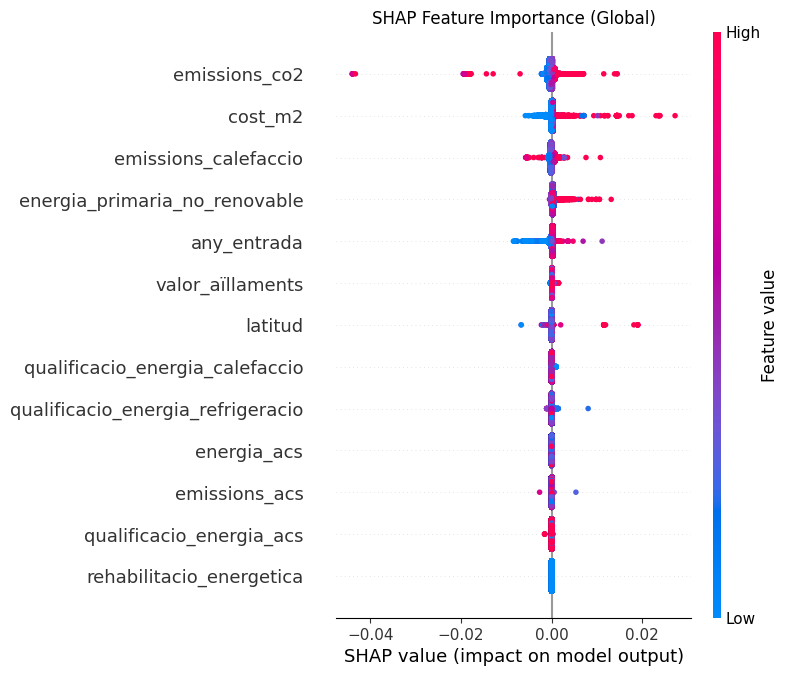


🔹 SHAP Explanation for Test Sample 5




🔹 Generating LIME explanation...



{'shap_values': .values =
 array([[-2.84975569e-04,  3.18156264e-04,  2.95054815e-05, ...,
         -8.20114292e-06, -5.50038123e-07, -1.01930448e-06],
        [-2.50260025e-04,  2.02213138e-04,  2.96906219e-05, ...,
         -1.16846695e-05,  1.38396319e-06, -3.93805948e-08],
        [-3.99567856e-04,  1.93585322e-04,  5.67620327e-06, ...,
          1.44020523e-05,  3.69823374e-06, -2.20205614e-08],
        ...,
        [-3.89247289e-04,  4.82791889e-04,  3.90937821e-05, ...,
         -8.12980034e-06,  1.24461030e-06, -3.02437471e-08],
        [-2.77140905e-04,  3.23837157e-04,  3.47768400e-05, ...,
         -4.90333650e-06,  2.64477285e-06, -4.30750795e-08],
        [-6.58354838e-05,  2.10609025e-04,  3.85825806e-05, ...,
         -2.73399201e-06, -3.53337714e-06,  1.29230358e-07]], dtype=float32)
 
 .base_values =
 array([0.00422629, 0.00422629, 0.00422629, ..., 0.00422629, 0.00422629,
        0.00422629], dtype=float32)
 
 .data =
 array([[0.00744723, 0.00201857, 0.0199    , ..., 0

In [19]:
two_model_xgboost_explanations = explain_model_with_shap_lime(
    model= two_models_results['trained_models']['XGBoost'],
    X_train = two_models_results['X_train'],
    X_test =  two_models_results['X_test'],
    sample_idx=5
    )

two_model_xgboost_explanations

<div id='i9ZDQ90V4JQ8RCJ0JTKY7'>
<div style='color: #900; text-align: center;'>
  <b>Visualization omitted, Javascript library not loaded!</b><br>
  Have you run `initjs()` in this notebook? If this notebook was from another
  user you must also trust this notebook (File -> Trust notebook). If you are viewing
  this notebook on github the Javascript has been stripped for security. If you are using
  JupyterLab this error is because a JupyterLab extension has not yet been written.
</div></div>
 <script>
   if (window.SHAP) SHAP.ReactDom.render(
    SHAP.React.createElement(SHAP.AdditiveForceVisualizer, {"outNames": ["f(x)"], "baseValue": 0.00422629015520215, "outValue": 0.002414081245660782, "link": "identity", "featureNames": ["emissions_calefaccio", "energia_primaria_no_renovable", "valor_a\u00efllaments", "any_entrada", "emissions_acs", "emissions_co2", "energia_acs", "latitud", "cost_m2", "rehabilitacio_energetica", "qualificacio_energia_calefaccio", "qualificacio_energia_refrigeracio", "qualificacio_energia_acs"], "features": {"0": {"effect": -0.00015377296949736774, "value": 0.007427474593488233}, "1": {"effect": 0.0002053154748864472, "value": 0.0016525632953692092}, "2": {"effect": -7.817526056896895e-05, "value": 0.0}, "3": {"effect": -0.00026578205870464444, "value": 0.10000000000002274}, "4": {"effect": 4.879987045569578e-07, "value": 0.0008279080653586117}, "5": {"effect": -0.0002838812943082303, "value": 0.0005243275916675124}, "6": {"effect": -1.3040180419920944e-06, "value": 0.0007010838459694262}, "7": {"effect": -5.351703293854371e-06, "value": 0.3997648189651031}, "8": {"effect": -0.0012261406518518925, "value": 6.436242249457526e-05}, "10": {"effect": -3.951271082769381e-06, "value": 0.6666666666666666}, "11": {"effect": 3.8579332795052323e-07, "value": 0.3333333333333333}, "12": {"effect": -3.9000966012281424e-08, "value": 1.0}}, "plot_cmap": "RdBu", "labelMargin": 20}),
    document.getElementById('i9ZDQ90V4JQ8RCJ0JTKY7')
  );
</script>

In [ ]:
two_model_rf_explanations = explain_model_with_shap_lime(
    model= two_models_results['trained_models']['Random Forest'],
    X_train = two_models_results['X_train'],
    X_test =  two_models_results['X_test'],
    sample_idx=3
    )

two_model_rf_explanations


🔹 Generating SHAP explanations...



In [20]:
y_train_pred = two_models_results['y_train_pred']
y_test_pred = two_models_results['y_test_pred']

X_test = two_models_results['X_test']
X_train = two_models_results['X_train']
y_train_pred

,consum_energia_final,Random Forest,XGBoost
0,0.005013,0.005013,0.004795
1,0.006034,0.006027,0.006115
2,0.004238,0.004238,0.004527
3,0.002275,0.002289,0.002925
4,0.003051,0.002884,0.002630
...,...,...,...
1329433,0.011379,0.010139,0.009717
1329434,0.005788,0.005787,0.005334
1329435,0.002114,0.003540,0.004692
1329436,0.005081,0.005081,0.004850


In [31]:
df['us_edifici']

index
0          Vivienda individual en bloque de viviendas
1                               Habitatge unifamiliar
2                               Habitatge unifamiliar
3                               Habitatge unifamiliar
4                                            Terciari
                              ...                    
1336920     Habitatge individual en bloc d'habitatges
1336921     Habitatge individual en bloc d'habitatges
1336922     Habitatge individual en bloc d'habitatges
1336923                         Habitatge unifamiliar
1336924     Habitatge individual en bloc d'habitatges
Name: us_edifici, Length: 1329439, dtype: category
Categories (11, object): ['Bloc d'habitatges', 'Bloc d'habitatges plurifamiliar', 'Bloque de viviendas', 'Bloque de viviendas plurifamiliar', ..., 'Terciari', 'Terciario', 'Vivienda individual en bloque de viviendas', 'Vivienda unifamiliar']

In [35]:
# First, ensure `y_train_pred` has the correct index
y_train_pred = y_train_pred.loc[X_train.index]
y_test_pred = y_test_pred.loc[X_test.index]

# Now, assign construction_year safely
y_train_pred["any_construccio_lri"] = df["any_construccio_lri"].reindex(X_train.index).values
y_test_pred["any_construccio_lri"] = df["any_construccio_lri"].reindex(X_test.index).values

y_train_pred["metres_cadastre"] = df["metres_cadastre"].reindex(X_train.index).values
y_test_pred["metres_cadastre"] = df["metres_cadastre"].reindex(X_test.index).values


In [ ]:
# y_test_pred.drop(columns='us_edifici', inplace=True)
# y_train_pred.drop(columns='us_edifici', inplace=True)
y_train_pred

,consum_energia_final,Random Forest,XGBoost,any_construccio_lri,metres_cadastre
847046,0.005527,0.005530,0.005331,2001.662354,53.00
677236,0.004007,0.004007,0.004131,1990.188965,144.39
543303,0.004693,0.004689,0.004413,1974.180664,55.00
299486,0.004457,0.004445,0.004256,1966.717529,56.60
701569,0.004853,0.004854,0.004203,1979.302734,52.70
...,...,...,...,...,...
839891,0.006439,0.006448,0.005796,1997.051147,77.00
535030,0.002038,0.002038,0.002589,1996.327881,64.00
573977,0.002038,0.002038,0.002405,1993.357178,97.00
1238212,0.004299,0.004300,0.004342,1962.737427,65.00


In [40]:
error_perc_change = y_train_pred.copy()
for c in error_perc_change:
    error_perc_change[f'{c}_error'] = round(abs(error_perc_change[c] - error_perc_change['consum_energia_final'])/error_perc_change['consum_energia_final'] * 100, 2)
error_perc_change.drop('consum_energia_final_error', axis=1, inplace=True)
error_perc_change

,consum_energia_final,Random Forest,XGBoost,any_construccio_lri,metres_cadastre,Random Forest_error,XGBoost_error,any_construccio_lri_error,metres_cadastre_error
847046,0.005527,0.005530,0.005331,2001.662354,53.00,0.06,3.54,36216024.21,958830.25
677236,0.004007,0.004007,0.004131,1990.188965,144.39,0.00,3.10,49671133.71,3603592.70
543303,0.004693,0.004689,0.004413,1974.180664,55.00,0.08,5.97,42068739.97,1171923.53
299486,0.004457,0.004445,0.004256,1966.717529,56.60,0.26,4.51,44127629.41,1269848.25
701569,0.004853,0.004854,0.004203,1979.302734,52.70,0.03,13.39,40789183.44,1085936.61
...,...,...,...,...,...,...,...,...,...
839891,0.006439,0.006448,0.005796,1997.051147,77.00,0.14,9.99,31013294.67,1195678.78
535030,0.002038,0.002038,0.002589,1996.327881,64.00,0.00,27.01,97941681.67,3139802.06
573977,0.002038,0.002038,0.002405,1993.357178,97.00,0.00,18.01,97795936.09,4758814.06
1238212,0.004299,0.004300,0.004342,1962.737427,65.00,0.02,1.00,45654694.55,1511850.40


In [51]:
# Remove incorrect error columns
error_perc_change.drop(columns=['any_construccio_lri_error', 'metres_cadastre_error'], inplace=True)

error_perc_change.describe()

,consum_energia_final,Random Forest,XGBoost,any_construccio_lri,metres_cadastre,Random Forest_error,XGBoost_error
count,1.196495e+06,1.196495e+06,1.196495e+06,1.189806e+06,1.189806e+06,1.196495e+06,1.196495e+06
mean,4.226722e-03,4.227063e-03,4.226290e-03,1.977797e+03,1.403857e+02,1.143395e+00,1.178009e+01
std,2.313727e-03,2.052118e-03,1.256339e-03,1.515693e+01,8.593400e+02,7.229039e+00,1.523499e+01
min,1.036352e-03,1.237512e-03,2.207612e-03,1.824631e+03,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.284472e-03,3.306626e-03,3.590106e-03,1.968402e+03,5.800000e+01,0.000000e+00,3.320000e+00
50%,4.170280e-03,4.170280e-03,4.202421e-03,1.978230e+03,7.480000e+01,3.000000e-02,6.920000e+00
75%,4.994486e-03,4.985419e-03,4.785764e-03,1.988484e+03,1.040000e+02,2.400000e-01,1.533000e+01
max,1.000000e+00,6.344005e-01,5.581701e-01,2.024124e+03,3.577920e+05,2.406650e+03,8.471300e+02


In [52]:
error_perc_change.mean().iloc[-8:]

consum_energia_final       0.004227
Random Forest              0.004227
XGBoost                    0.004226
any_construccio_lri     1977.796753
metres_cadastre          140.385694
Random Forest_error        1.143395
XGBoost_error             11.780091
dtype: float64

In [54]:
# Find the top 1% largest errors
threshold_rf = error_perc_change["Random Forest_error"].quantile(0.99)
threshold_xgb = error_perc_change["XGBoost_error"].quantile(0.99)

outliers = error_perc_change[
    (error_perc_change["Random Forest_error"] > threshold_rf) |
    (error_perc_change["XGBoost_error"] > threshold_xgb)
]

outliers


,consum_energia_final,Random Forest,XGBoost,any_construccio_lri,metres_cadastre,Random Forest_error,XGBoost_error
104858,0.002154,0.002153,0.003856,1988.361450,66.00,0.04,79.02
79796,0.002509,0.003535,0.003474,1993.186890,109.00,40.89,38.44
204432,0.002588,0.003036,0.004608,1991.433838,169.00,17.30,78.05
632714,0.002584,0.003179,0.003858,1990.921509,110.00,23.01,49.28
440947,0.003053,0.004004,0.006737,1972.843872,59.00,31.17,120.70
...,...,...,...,...,...,...,...
810539,0.002092,0.002090,0.005165,1980.676270,64.00,0.11,146.83
1135891,0.002449,0.002972,0.004668,1991.822998,55.00,21.36,90.58
423261,0.002494,0.002494,0.004696,1976.502197,91.00,0.00,88.31
610950,0.002065,0.002170,0.003906,1975.206177,73.96,5.10,89.17


In [ ]:
# Create a new column for construction decade
error_perc_change["construction_decade"] = (error_perc_change["any_construccio_lri"] // 10) * 10

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Error by construction decade
sns.boxplot(x="construction_decade", y="Random Forest_error", data=error_perc_change, ax=ax[0])
ax[0].set_title("Random Forest Error by Construction Decade")

# Error by building size/area
sns.boxplot(x="metres_cadastre", y="Random Forest_error", data=error_perc_change, ax=ax[1])
ax[1].set_title("Random Forest Error by Building Area")

plt.xticks(rotation=45)
plt.show()


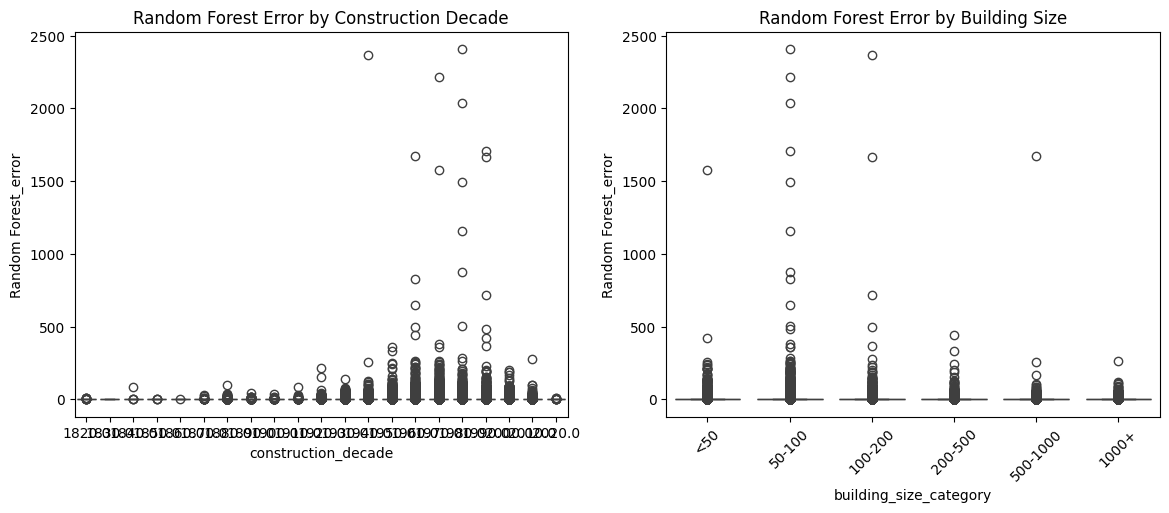

In [62]:
# Create a new column for construction decade (rounded to the nearest 10)
error_perc_change["construction_decade"] = (error_perc_change["any_construccio_lri"] // 10) * 10

# Convert to categorical type with ordered categories
sorted_decades = sorted(error_perc_change["construction_decade"].dropna().unique())
error_perc_change["construction_decade"] = pd.Categorical(error_perc_change["construction_decade"], categories=sorted_decades, ordered=True)

# Create bins for building size
size_bins = [0, 50, 100, 200, 500, 1000, error_perc_change["metres_cadastre"].max()]
size_labels = ["<50", "50-100", "100-200", "200-500", "500-1000", "1000+"]
error_perc_change["building_size_category"] = pd.cut(error_perc_change["metres_cadastre"], bins=size_bins, labels=size_labels)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Error by construction decade (corrected order)
sns.boxplot(x="construction_decade", y="Random Forest_error", data=error_perc_change, ax=ax[0])
ax[0].set_title("Random Forest Error by Construction Decade")

# Error by building size category
sns.boxplot(x="building_size_category", y="Random Forest_error", data=error_perc_change, ax=ax[1])
ax[1].set_title("Random Forest Error by Building Size")

plt.xticks(rotation=45)
plt.show()


**📊 Interpretation of the Boxplots**  

**1️⃣ Random Forest Error by Construction Decade**
- The **x-axis** represents the construction decade (e.g., 1900s, 1910s, ..., 2020s).
- The **y-axis** represents the percentage error in the predicted energy consumption.
- Each boxplot shows the **spread of errors** for buildings from that decade:
  - **Median (middle line)**: The typical prediction error.
  - **Interquartile Range (IQR - box height)**: How much errors vary for most buildings.
  - **Whiskers & Outliers**: Extreme prediction errors.

**🔎 Observations**  
- **Older buildings (pre-1950s)** tend to have **higher median errors** and more variation.
- **Newer buildings (post-2000s)** show more **consistent errors** (smaller boxes).
- Possible reasons:
  - **Older buildings** have more **heterogeneous construction standards**.
  - **Newer buildings** may have **better insulation & regulation**, making predictions more reliable.
  - **Renovations in older buildings** might introduce inconsistencies in energy use.

---

**2️⃣ Random Forest Error by Building Size**
- The **x-axis** represents building size categories (e.g., "<50m²", "50-100m²", etc.).
- The **y-axis** represents the model’s percentage error.

**🔎 Observations**  
- **Smaller buildings (<50m²)** may show **higher error rates**, possibly due to:
  - Variability in insulation & heating efficiency.
  - Higher energy intensity per square meter.
- **Medium-sized buildings (50-500m²)** may have **more stable predictions**.
- **Larger buildings (>1000m²)** might have **wider error margins**, possibly due to:
  - **Diverse energy use profiles** (e.g., mixed residential/commercial use).
  - **Shared heating systems** that introduce variability.

---

**Key Takeaways**
**Older buildings & small buildings tend to have higher prediction errors.**  
**Newer buildings & mid-sized homes have lower errors, making predictions more reliable.**  
**Consider segmenting models by construction period or building size to improve accuracy.**



In [ ]:
# models_names = ['Linear Model', 'Decision Tree', 'Random Forest', 'SVM']
# models_names = ['XGBoost','Random Forest']

In [43]:
two_models_results['y_train_pred']['consum_energia_final']

0          0.005013
1          0.006034
2          0.004238
3          0.002275
4          0.003051
             ...   
1329433    0.011379
1329434    0.005788
1329435    0.002114
1329436    0.005081
1329437    0.004233
Name: consum_energia_final, Length: 1196495, dtype: float64

In [ ]:
# error_perc_change['consum_energia_final']
# two_models_results['y_train_pred']['consum_energia_final']

In [44]:
two_models_results['y_train_pred']['consum_energia_final']

0          0.005013
1          0.006034
2          0.004238
3          0.002275
4          0.003051
             ...   
1329433    0.011379
1329434    0.005788
1329435    0.002114
1329436    0.005081
1329437    0.004233
Name: consum_energia_final, Length: 1196495, dtype: float64

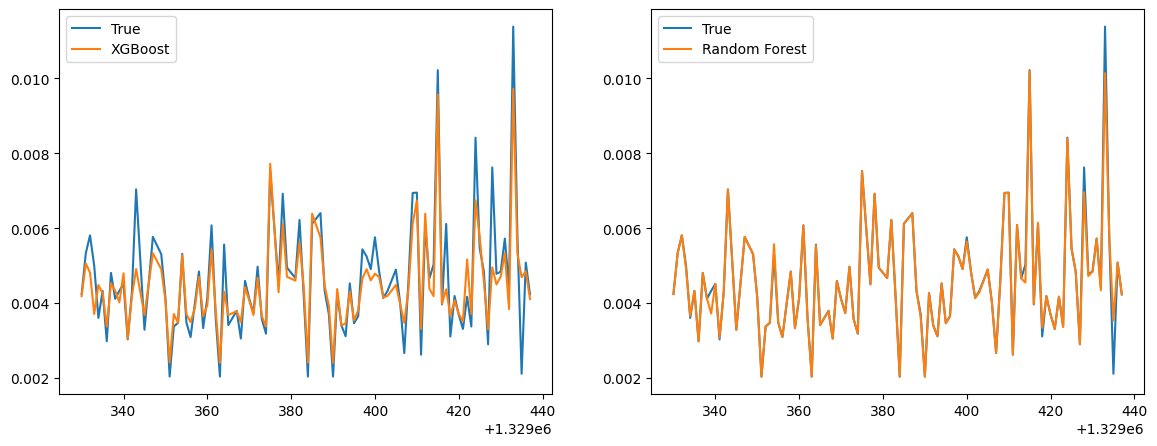

In [45]:
models_names = ['XGBoost','Random Forest']

# prediction test
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(two_models_results['y_train_pred']['consum_energia_final'][-100:], label='True')
    ax.plot(two_models_results['y_train_pred'][i][-100:], label=i)
    ax.legend(loc='upper left')

In [46]:
two_models_results['y_train_pred']

,consum_energia_final,Random Forest,XGBoost
0,0.005013,0.005013,0.004795
1,0.006034,0.006027,0.006115
2,0.004238,0.004238,0.004527
3,0.002275,0.002289,0.002925
4,0.003051,0.002884,0.002630
...,...,...,...
1329433,0.011379,0.010139,0.009717
1329434,0.005788,0.005787,0.005334
1329435,0.002114,0.003540,0.004692
1329436,0.005081,0.005081,0.004850


In [47]:
y_test_pred

,consum_energia_final,Random Forest,XGBoost,any_construccio_lri,metres_cadastre
1160182,0.002408,0.002237,0.003573,1983.981812,156.0
305962,0.002735,0.002732,0.003566,1996.607300,67.0
634120,0.002495,0.002744,0.003273,1979.222778,163.0
403271,0.003511,0.003512,0.003536,1982.700562,147.9
917615,0.003232,0.003229,0.003462,1985.728394,48.0
...,...,...,...,...,...
550756,0.002038,0.002038,0.002405,1994.517456,108.0
1257007,0.006150,0.006148,0.005624,1972.092529,67.0
327810,0.003910,0.003909,0.003802,1973.286499,34.0
205515,0.004170,0.004170,0.003693,1998.375122,42.0


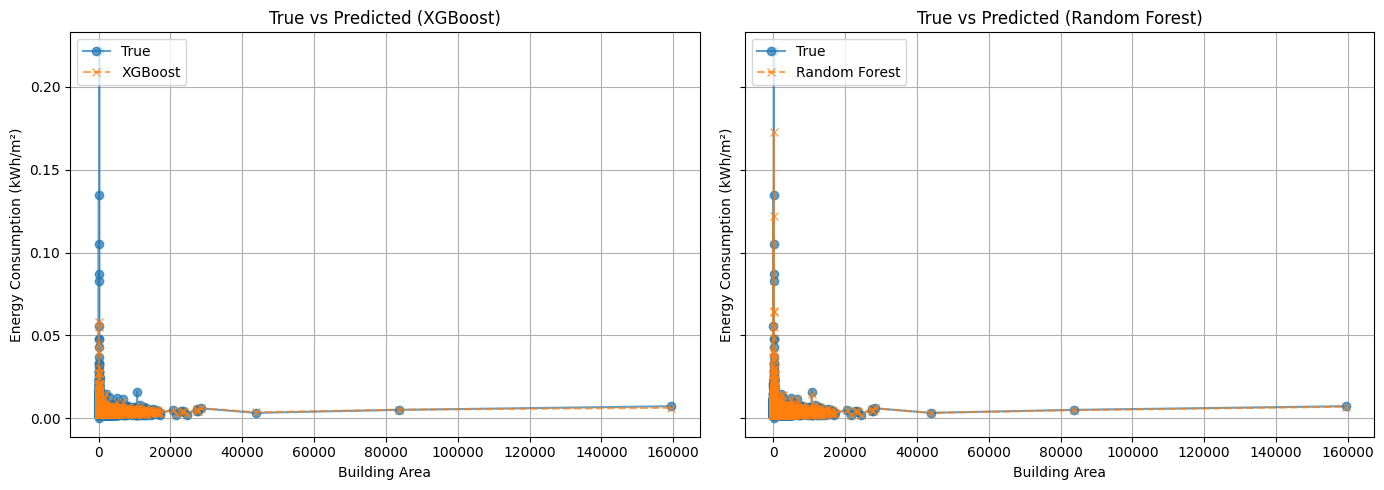

In [63]:

models_names = ['XGBoost', 'Random Forest']

# Sort values by construction year
y_test_pred_sorted = y_test_pred.sort_values(by='metres_cadastre')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(y_test_pred_sorted['metres_cadastre'], 
            y_test_pred_sorted['consum_energia_final'], 
            label='True', marker='o', linestyle='-', alpha=0.7)
    
    ax.plot(y_test_pred_sorted['metres_cadastre'], 
            y_test_pred_sorted[i], 
            label=i, marker='x', linestyle='--', alpha=0.7)

    ax.set_xlabel("Building Area")
    ax.set_ylabel("Energy Consumption (kWh/m²)")
    ax.set_title(f"True vs Predicted ({i})")
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()


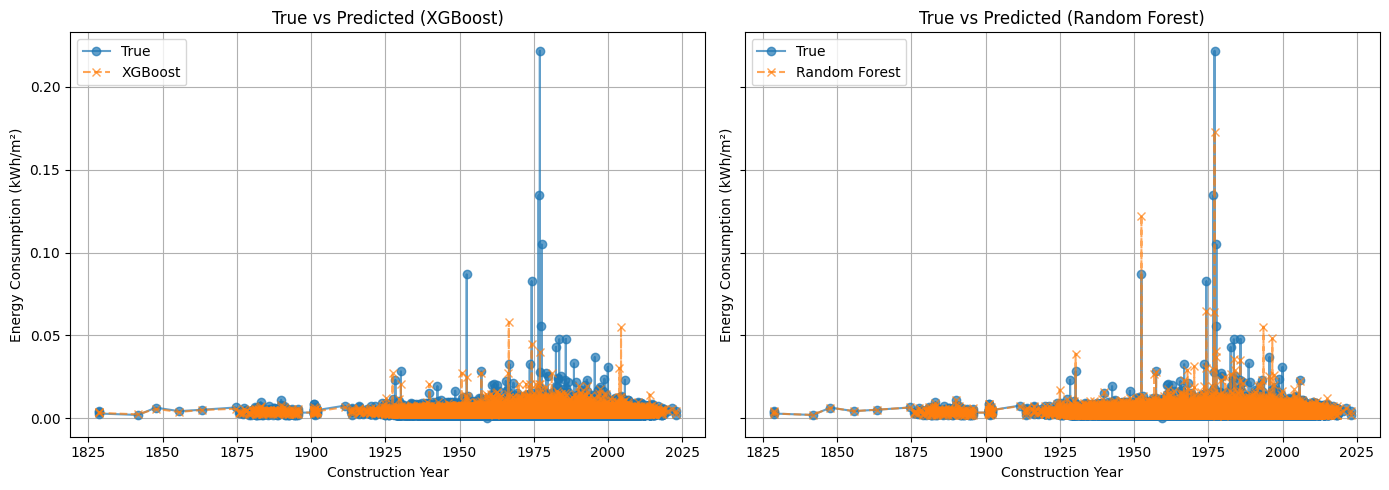

In [48]:

models_names = ['XGBoost', 'Random Forest']

# Sort values by construction year
y_test_pred_sorted = y_test_pred.sort_values(by='any_construccio_lri')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(y_test_pred_sorted['any_construccio_lri'], 
            y_test_pred_sorted['consum_energia_final'], 
            label='True', marker='o', linestyle='-', alpha=0.7)
    
    ax.plot(y_test_pred_sorted['any_construccio_lri'], 
            y_test_pred_sorted[i], 
            label=i, marker='x', linestyle='--', alpha=0.7)

    ax.set_xlabel("Construction Year")
    ax.set_ylabel("Energy Consumption (kWh/m²)")
    ax.set_title(f"True vs Predicted ({i})")
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()


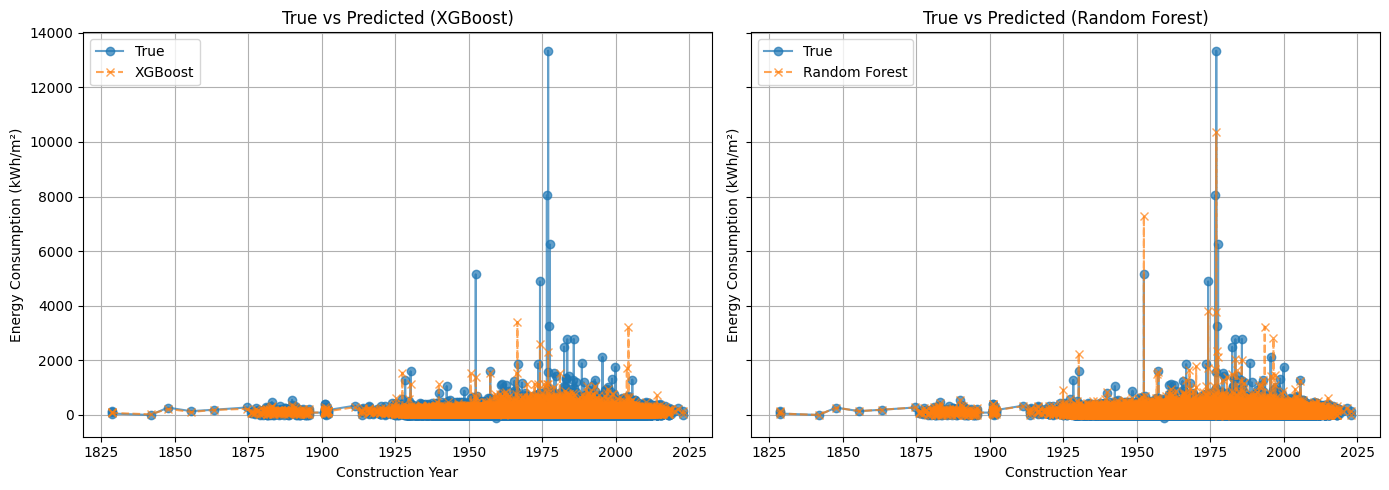

In [49]:

y_scaler = two_models_results['y_scaler']

# Inverse transform energy consumption values
y_test_pred_sorted = y_test_pred.sort_values(by='any_construccio_lri').copy()
y_test_pred_sorted[['consum_energia_final', 'XGBoost', 'Random Forest']] = y_scaler.inverse_transform(
    y_test_pred_sorted[['consum_energia_final', 'XGBoost', 'Random Forest']]
)

models_names = ['XGBoost', 'Random Forest']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(y_test_pred_sorted['any_construccio_lri'], 
            y_test_pred_sorted['consum_energia_final'], 
            label='True', marker='o', linestyle='-', alpha=0.7)
    
    ax.plot(y_test_pred_sorted['any_construccio_lri'], 
            y_test_pred_sorted[i], 
            label=i, marker='x', linestyle='--', alpha=0.7)

    ax.set_xlabel("Construction Year")
    ax.set_ylabel("Energy Consumption (kWh/m²)")
    ax.set_title(f"True vs Predicted ({i})")
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()


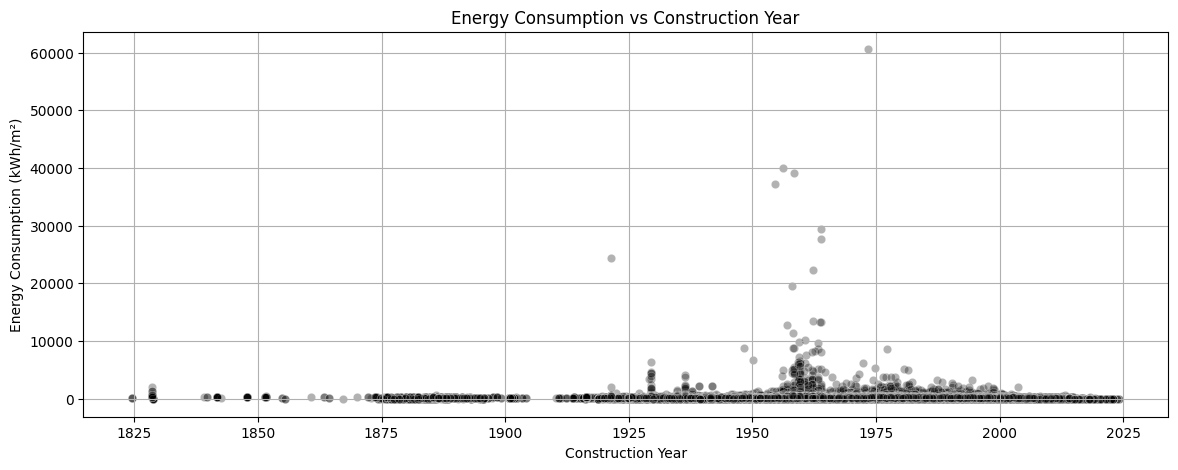

In [ ]:


plt.figure(figsize=(14, 5))

sns.scatterplot(data=df, x="any_construccio_lri", y="consum_energia_final", 
                color="black", alpha=0.3)

# Labels and title
plt.title("Energy Consumption vs Construction Year")
plt.xlabel("Construction Year")
plt.ylabel("Energy Consumption (kWh/m²)")
plt.grid(True)

plt.show()


In [ ]:
y_test_pred

,consum_energia_final,Random Forest,XGBoost,any_construccio_lri
1160182,0.002408,0.003879,0.003659,1983.981812
305962,0.002735,0.002939,0.003409,1996.607300
634120,0.002495,0.002495,0.002766,1979.222778
403271,0.003511,0.003512,0.003654,1982.700562
917615,0.003232,0.003232,0.003294,1985.728394
...,...,...,...,...
550756,0.002038,0.002038,0.002407,1994.517456
1257007,0.006150,0.006146,0.005880,1972.092529
327810,0.003910,0.003909,0.003909,1973.286499
205515,0.004170,0.004170,0.003964,1998.375122


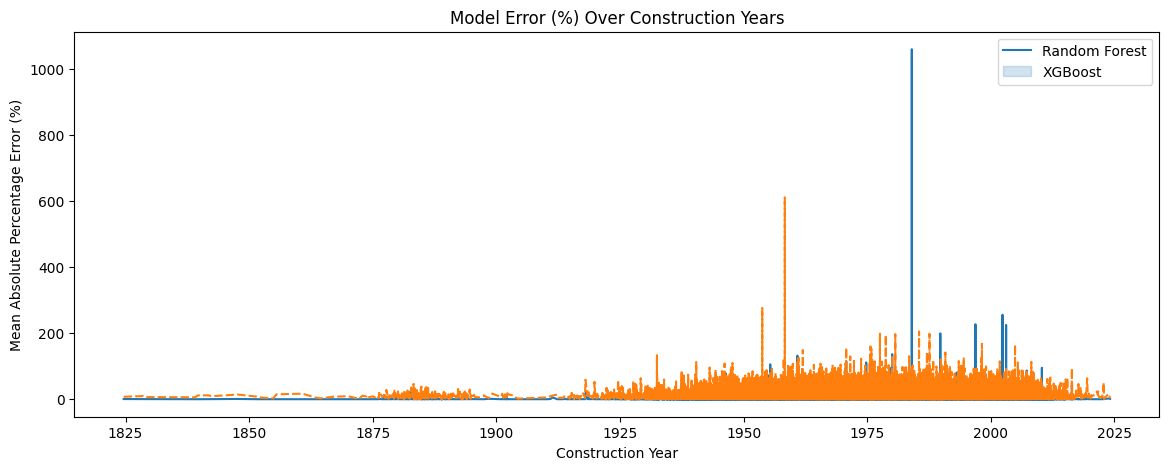

In [ ]:
# Aggregate mean error by construction year
error_by_year = error_perc_change.groupby("any_construccio_lri")[["Random Forest_error", "XGBoost_error"]].mean()

# Plot error trends over time
plt.figure(figsize=(14, 5))
sns.lineplot(data=error_by_year)
plt.title("Model Error (%) Over Construction Years")
plt.xlabel("Construction Year")
plt.ylabel("Mean Absolute Percentage Error (%)")
plt.legend(["Random Forest", "XGBoost"])
plt.show()


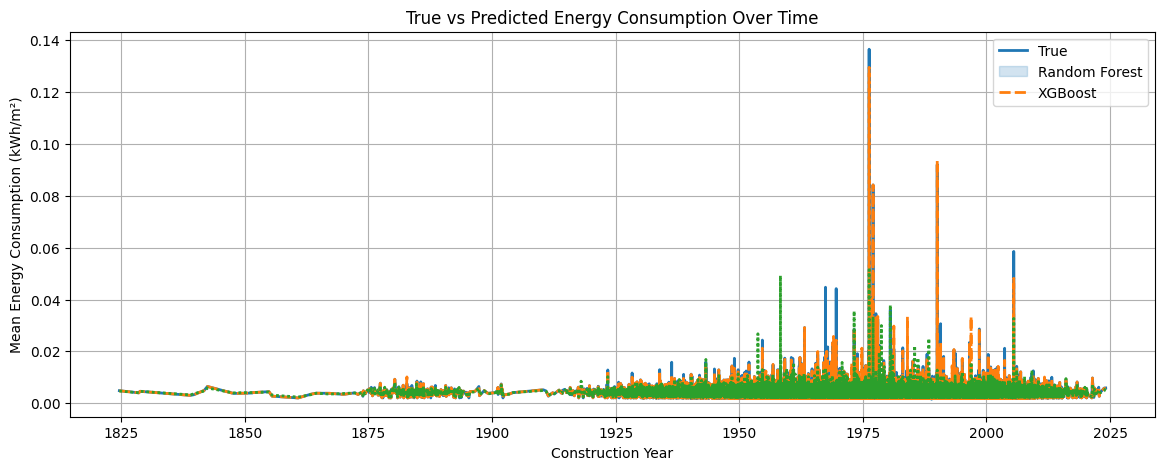

In [ ]:
# Aggregate mean values by construction year
df_plot = error_perc_change.groupby("any_construccio_lri")[["consum_energia_final", "Random Forest", "XGBoost"]].mean()

# Plot actual vs predicted values over time
plt.figure(figsize=(14, 5))
sns.lineplot(data=df_plot, linewidth=2)

# Add labels and title
plt.title("True vs Predicted Energy Consumption Over Time")
plt.xlabel("Construction Year")
plt.ylabel("Mean Energy Consumption (kWh/m²)")
plt.legend(["True", "Random Forest", "XGBoost"])
plt.grid(True)

# Show the plot
plt.show()


In [65]:

# Define path where model results were saved
results_save_path = os.path.join(two_save_path, "two_models_results.pkl")

# Load the saved model results
two_models_results = joblib.load(results_save_path)

# Check the loaded results structure
print(two_models_results.keys())  # Should contain 'trained_models', 'X_train', 'X_test', etc.


dict_keys(['predictors', 'trained_models', 'X_train', 'X_test', 'y_train', 'y_test', 'train_scores_df', 'test_scores_df', 'feature_importances', 'label_encoders', 'x_scaler', 'y_scaler', 'y_train_pred', 'y_test_pred'])


In [ ]:
# model = all_results['trained_models']['Gradient Boosting']
# X = all_results['predictors']
# gb_explainer = shap.Explainer(model)
# shap_values = explainer(X)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

### 4. Tuning

Tuning starts here

In [ ]:
"../outputs/tuned/"

'../outputs/checkpoint/all'

In [192]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import pandas as pd

def train_energy_consumption_models_with_tuning(
    df, models, target, num_cols, cat_cols, save_path="models/",
    scale=True, shuffle=True, stratify=False, save=False, test_size=0.2
):
    """
    Train multiple models to predict energy consumption (kWh/m²) with optional scaling, shuffling, and stratification.
    Includes minimal hyperparameter tuning for Random Forest model using GridSearchCV.

    Args:
        df (pd.DataFrame): Cleaned dataset.
        models (dict): Dictionary of models to train.
        target (str): Name of the target variable.
        num_cols (list): List of numerical feature column names.
        cat_cols (list): List of categorical feature column names.
        save_path (str): Directory path to save trained models.
        scale (bool): Whether to apply MinMax scaling to features and target.
        shuffle (bool): Whether to shuffle the dataset before splitting.
        stratify (bool): Whether to stratify the dataset based on the target variable.

    Returns:
        results (dict): Dictionary containing trained models, scores, and transformation objects.
    """
    # Ensure target is not included in feature lists
    num_cols = [col for col in num_cols if col != target]
    cat_cols = [col for col in cat_cols if col != target]
    
    # Ensure save path exists
    os.makedirs(save_path, exist_ok=True)
    
    # Encode categorical variables
    label_encoders = {}
    print("\n🔹 Encoding categorical variables...")
    for col in tqdm(cat_cols, desc="Encoding Progress"):
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # Store encoders for later use
    
    # Prepare features and target
    X = df[num_cols + cat_cols]
    y = df[[target]]
    
    # Apply MinMax Scaling if enabled
    x_scaler, y_scaler = None, None
    if scale:
        x_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
        X = pd.DataFrame(x_scaler.fit_transform(X), columns=X.columns)
        y = pd.DataFrame(y_scaler.fit_transform(y), columns=[target])
    
    # Define stratification strategy
    stratify_y = y if stratify else None
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=7, shuffle=shuffle, stratify=stratify_y
    )
    
    train_scores = {}
    test_scores = {}
    trained_models = {}
    feature_importances = {}

    metrics = ["MAE", "RMSE", "R²"]

    y_test_pred = y_test.copy()
    y_train_pred = y_train.copy()
    
    # Hyperparameter tuning for RandomForest
    rf_params = {
        'n_estimators': [25, 35],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    
    for name, model in tqdm(models.items(), desc="Training and Tuning Models"):
        print(f"\n🔹 Training {name}...")
        
        if name == 'RandomForest':
            # Apply GridSearchCV for RandomForest model
            grid_search = GridSearchCV(model, rf_params, cv=5, n_jobs=-1)
            grid_search.fit(X_train, y_train.values.ravel())
            model = grid_search.best_estimator_  # Get best model after tuning
            print(f"Best parameters for {name}: {grid_search.best_params_}")
        
        # Train the model
        model.fit(X_train, y_train.values.ravel())  # Flatten y_train to avoid warnings
        
        # Make predictions
        y_train_pred[name] = model.predict(X_train).flatten()
        y_test_pred[name] = model.predict(X_test).flatten()

        # Compute metrics using only the current model’s predictions
        train_scores[name] = [
            mean_absolute_error(y_train, y_train_pred[name]),  # Use only the current model's column
            root_mean_squared_error(y_train, y_train_pred[name]),
            r2_score(y_train, y_train_pred[name])
        ]

        test_scores[name] = [
            mean_absolute_error(y_test, y_test_pred[name]),  # Use only the current model's column
            root_mean_squared_error(y_test, y_test_pred[name]),
            r2_score(y_test, y_test_pred[name])
        ]

        trained_models[name] = model  # Store trained model
        
        # Save trained model checkpoint
        model_path = os.path.join(save_path, f"{name.replace(' ', '_')}.pkl")
        if save:
            joblib.dump(model, model_path)
        
        # Extract feature importances if applicable
        if hasattr(model, "feature_importances_"):
            importance_df = pd.DataFrame(
                {"Feature": X.columns, "Importance": model.feature_importances_}
            ).sort_values(by="Importance", ascending=False).head(10)
            feature_importances[name] = importance_df

    y_test_pred.sort_index(inplace=True)
    y_train_pred.sort_index(inplace=True)
    
    # Convert scores to DataFrames
    train_scores_df = pd.DataFrame(train_scores, index=metrics).T
    test_scores_df = pd.DataFrame(test_scores, index=metrics).T
    
    results = {
        "predictors": X,
        "trained_models": trained_models,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "train_scores_df": train_scores_df,
        "test_scores_df": test_scores_df,
        "feature_importances": feature_importances,
        "label_encoders": label_encoders,
        "x_scaler": x_scaler,
        "y_scaler": y_scaler,
        "y_train_pred": y_train_pred,
        "y_test_pred": y_test_pred
    }

    return results


# Define the models to train
model = {
    "RandomForest": RandomForestRegressor(),
    # "LinearRegression": LinearRegression(),
    # "SVR": SVR()
}

tune_save_path = "../outputs/tuned/"

# Train models with minimal tuning on RandomForest
results = train_energy_consumption_models_with_tuning(
    df=df,
    models = model,
    target=target,
    num_cols=num_features,
    cat_cols=cat_features_all,
    save_path=tune_save_path,
    scale=True,  # Apply scaling
    shuffle=True,  # Shuffle data before splitting
    stratify=False,  # No stratification
    save=True,  # Save the trained models
    test_size=0.1  # Split data into 80% train and 20% test
)

# Access results
print("Training Results:")
print(results["train_scores_df"])  # Model performance on training set
print(results["test_scores_df"])  # Model performance on test set

# Access feature importances (only for models that support it like RandomForest)
print("\nFeature Importances (RandomForest):")
print(results["feature_importances"]["RandomForest"])

# Access the trained RandomForest model after tuning
# best_rf_model = results["trained_models"]["RandomForest"]



🔹 Encoding categorical variables...


Training and Tuning Models:   0%|          | 0/1 [00:00<?, ?it/s]


🔹 Training RandomForest...


Training and Tuning Models:   0%|          | 0/1 [1:22:50<?, ?it/s]


KeyboardInterrupt: 

### 5. Apply your model to a real-world case

1. **Feature Selection for Cost-Effectiveness Modeling**  
   - **Building Characteristics**: Construction year (`any_construccio`), floor area (`metres_cadastre`), insulation levels (`valor_aïllaments`), window quality (`valor_finestres`), and HVAC systems.
   - **Energy Performance Metrics**: Energy consumption (`consum_energia_final`), CO₂ emissions (`emissions_co2`), and energy efficiency ratings (`qualificacio_energia_calefaccio`, etc.).
   - **Renovation Variables**: Type of intervention (`actuacions_rehabilitacio`), renewable energy integration (`solar_termica`, `energia_geotermica`), and estimated renovation cost (to be modeled).
   - **Financial Variables**: Energy cost before and after renovation (`cost_anual_energia_habitatge`), investment cost (`cost_renovacio`), and payback period.

2. **Predicting Renovation Costs**  
   - Using machine learning models (e.g., Random Forest, Gradient Boosting) trained on known renovation projects to estimate missing cost data.
   - Including proxy variables such as insulation upgrades and window replacements.

3. **Evaluating Cost-Effectiveness**  
   - Comparing energy cost savings with renovation investments.
   - Using Net Present Value (NPV) and Internal Rate of Return (IRR) for financial viability.
   - Clustering similar buildings to derive cost benchmarks.

4. **Benchmarking Against Real-World Renovation Data**  
   - Studies on my building projects indicate that deep renovations (comprehensive upgrades) typically yield the highest energy savings but require substantial upfront investment.


In [77]:
catalonia_analysis_df[['sistema_biomassa','solar_termica']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1329439 entries, 0 to 1336924
Data columns (total 2 columns):
 #   Column            Non-Null Count    Dtype
---  ------            --------------    -----
 0   sistema_biomassa  1329439 non-null  int8 
 1   solar_termica     1329439 non-null  int8 
dtypes: int8(2)
memory usage: 44.9 MB


In [ ]:
# def estimate_renovation_cost(row):
#     """Estimate renovation costs based on building characteristics."""
#     base_cost_per_m2 = 300  # Baseline cost per m² (can be adjusted)
    
#     # Convert categorical variables to numeric codes
#     row["sistema_biomassa"] = catalonia_analysis_df["sistema_biomassa"].cat.codes
#     row["solar_termica"] = catalonia_analysis_df["solar_termica"].cat.codes


#     # Adjustments for specific upgrades
#     insulation_factor = 1.2 if row["valor_aïllaments"] > 0 else 1.0
#     windows_factor = 1.15 if row["valor_finestres"] > 0 else 1.0
#     biomass_factor = 1.3 if row["sistema_biomassa"] > 0 else 1.0
#     solar_factor = 1.25 if row["solar_termica"] > 0 or row["energia_geotermica"] > 0 else 1.0
    
#     # Compute estimated cost
#     estimated_cost = (row["metres_cadastre"] * base_cost_per_m2 *
#                       insulation_factor * windows_factor * biomass_factor * solar_factor)
    
#     return estimated_cost

# # Apply estimation function
# catalonia_analysis_df["cost_renovacio"] = catalonia_analysis_df.apply(estimate_renovation_cost, axis=1)


In [81]:
catalonia_analysis_df[["any_construccio_lri", "metres_cadastre", "valor_aïllaments", "valor_finestres",
                 "sistema_biomassa", "solar_termica", "energia_geotermica"]].head(2)

,any_construccio_lri,metres_cadastre,valor_aïllaments,valor_finestres,sistema_biomassa,solar_termica,energia_geotermica
index,,,,,,,
0,1978.053589,55.0,0.73,3.78,0,0,NO
1,1993.678101,116.0,2.94,5.00,0,0,NO


In [ ]:
# Convert categorical variables to numeric codes
catalonia_analysis_df["sistema_biomassa"] = catalonia_analysis_df["sistema_biomassa"].cat.codes
catalonia_analysis_df["solar_termica"] = catalonia_analysis_df["solar_termica"].cat.codes


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Ensure cost_renovacio exists
if "cost_renovacio" not in catalonia_analysis_df.columns:
    catalonia_analysis_df["cost_renovacio"] = np.nan  # Placeholder

# Apply heuristic: Assume 200€/m² with insulation adjustments
catalonia_analysis_df["cost_renovacio"] = (
    200 * catalonia_analysis_df["metres_cadastre"] * (1 + 0.2 * catalonia_analysis_df["valor_aïllaments"])
)

# Define relevant features
cost_features = ["any_construccio_lri", "metres_cadastre", "valor_aïllaments", "valor_finestres",
                 "sistema_biomassa", "solar_termica"]

# **Fix: Drop rows where cost_renovacio is NaN**
df_cost_train = catalonia_analysis_df.dropna(subset=["cost_renovacio"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_cost_train[cost_features], df_cost_train["cost_renovacio"], 
    test_size=0.2, random_state=42
)


print("Training model...")
with tqdm(total=10) as pbar:
    cost_model = RandomForestRegressor(n_estimators=10, random_state=42)
    cost_model.fit(X_train, y_train)
    pbar.update(10)
print("Training complete!")

# Evaluate model
y_pred = cost_model.predict(X_test)
print(f"MAE (Cost Prediction): {mean_absolute_error(y_test, y_pred):,.2f} €")

# **Optimized Prediction for Missing Values**
print("Predicting renovation costs (batch processing)...")
mask_missing = catalonia_analysis_df["cost_renovacio"].isna()
catalonia_analysis_df.loc[mask_missing, "cost_renovacio"] = cost_model.predict(
    catalonia_analysis_df.loc[mask_missing, cost_features]
)
print("Renovation cost predictions complete!")


# Define historic building attributes
historic_building = pd.DataFrame({
    "any_construccio_lri": [1990],  # I'm using my rented apartment built around this time
    "metres_cadastre": [500],  
    "valor_aïllaments": [0],  
    "valor_finestres": [0],  
    "sistema_biomassa": [0],  
    "solar_termica": [0],  
    "energia_geotermica": [0]  
})

# **Fix Warning: Pass a DataFrame, not an array**
historic_building["cost_renovacio"] = cost_model.predict(historic_building[cost_features])

print(f"Estimated renovation cost: {historic_building['cost_renovacio'][0]:,.2f} €")


Training model...


100%|██████████| 10/10 [00:45<00:00,  4.50s/it]


Training complete!
MAE (Cost Prediction): 227.67 €
Predicting renovation costs (batch processing)...
Renovation cost predictions complete!
Estimated renovation cost: 100,038.80 €



---

Next is to analyze the cost-effectiveness of renovations by estimating energy savings and computing the payback period. This will directly show whether the renovation cost is justified based on energy savings.

Implementation Plan:

1. Estimate energy savings
 - Predict the building’s energy consumption before and after renovation.
 - Compute the reduction in energy use.
2. Calculate cost savings
 - Multiply energy savings by the cost of energy (€/kWh).
3. Compute payback period
 - Divide renovation cost by annual energy cost savings.
 - This tells us how long it takes for the investment to pay off.


---
---

We now use the trained **Random Forest (best option)** or **XGBoost** model from `train_energy_consumption_models()`.  

**Steps to Integrate the Trained Model**
1. **Retrieve the best-trained model** from `two_models_results`  
   - The **Random Forest** model performed best with an **R² of 0.91** (high accuracy).  
   - The **XGBoost** model had lower performance (**R² of 0.55**).  
   
2. **Use the trained model for predictions**  
   - Extract the trained Random Forest model.  
   - Predict **energy consumption before renovation** for the **historic building**.  
   - Later, adjust its features (e.g., better insulation, solar panels) and predict **after renovation**.  

---


In [96]:
two_models_results.keys()

dict_keys(['predictors', 'trained_models', 'X_train', 'X_test', 'y_train', 'y_test', 'train_scores_df', 'test_scores_df', 'feature_importances', 'label_encoders', 'x_scaler', 'y_scaler', 'y_train_pred', 'y_test_pred'])

We will:

1. Extract the exact feature list used during training.
2. Reformat the historic building data to match.
3. Apply the trained x_scaler (if scaling was used).
4. Use the trained model for prediction.

In [101]:
two_models_results['predictors'].head()

,emissions_calefaccio,energia_primaria_no_renovable,valor_aïllaments,any_entrada,emissions_acs,emissions_co2,energia_acs,latitud,cost_m2,rehabilitacio_energetica,qualificacio_energia_calefaccio,qualificacio_energia_refrigeracio,qualificacio_energia_acs
0,0.008511,0.003207,0.0073,0.9,0.001647,0.000969,0.001646,0.395998,0.000069,0.0,0.666667,0.333333,1.000000
1,0.019517,0.003493,0.0294,0.5,0.000483,0.001386,0.000336,0.395998,0.000067,0.0,0.833333,0.333333,0.500000
2,0.010018,0.003201,0.0119,0.7,0.000458,0.000867,0.000458,0.395998,0.000067,0.0,0.833333,0.666667,1.000000
3,0.000717,0.000790,0.0043,0.7,0.000161,0.000214,0.000161,0.395998,0.000065,0.0,0.000000,0.000000,0.000000
4,0.000082,0.000756,0.0030,0.8,0.000313,0.000205,0.000312,0.395998,0.000064,0.0,0.000000,0.000000,0.333333


In [105]:
two_models_results['predictors'].columns

Index(['emissions_calefaccio', 'energia_primaria_no_renovable',
       'valor_aïllaments', 'any_entrada', 'emissions_acs', 'emissions_co2',
       'energia_acs', 'latitud', 'cost_m2', 'rehabilitacio_energetica',
       'qualificacio_energia_calefaccio', 'qualificacio_energia_refrigeracio',
       'qualificacio_energia_acs'],
      dtype='object')

In [ ]:
# Extract trained Random Forest model
energy_model = two_models_results['trained_models']['Random Forest']

# Extract features used during training
energy_features = list(two_models_results['predictors'].columns)

# Define historic building attributes with placeholders for missing features
historic_building = pd.DataFrame({col: [0] for col in energy_features})  # Default to 0

# Set actual values for relevant features 
# historic_building["any_entrada"] = [1990]  # Proxy for construction year
historic_building["any_construccio_lri"] = [1990]  # Proxy for construction year
historic_building["valor_aïllaments"] = [0.09]  
historic_building["cost_m2"] = [20]  # Assumed renovation cost per m²
historic_building["rehabilitacio_energetica"] = [0]  # No prior renovations
historic_building["emissions_calefaccio"] = [0.008]
historic_building["emissions_acs"] = [0.0016]
historic_building["emissions_co2"] = [0.008]
historic_building["latitud"] = [0.395] # location of my building
historic_building["qualificacio_energia_acs"] = [1]
historic_building["qualificacio_energia_calefaccio"] = [0.333]
historic_building["qualificacio_energia_refrigeracio"] = [1]
historic_building["qualificacio_energia_acs"] = [1]
 

# Ensure feature order matches training set
historic_building = historic_building[energy_features]

# Predict energy consumption before renovation
historic_building["consum_energia_final_before"] = energy_model.predict(historic_building)
# historic_building["consum_energia_final_before"] *= 365 # for yearly 

print(f"Estimated energy consumption before renovation: {historic_building['consum_energia_final_before'][0]:,.2f} kWh/m²")

# Reshape the array before applying inverse transformation
historic_building["consum_energia_final_before"] = two_models_results['y_scaler'].inverse_transform(
    historic_building[["consum_energia_final_before"]].values.reshape(-1, 1)
)

print(f"Corrected Estimated Energy Consumption Before Renovation: {historic_building['consum_energia_final_before'][0]:.2f} kWh/m²")



Estimated energy consumption before renovation: 0.10 kWh/m²


`Since MinMaxScaler was used during training, the predicted energy consumption (0.10 kWh/m²) is scaled and needs to be inverse transformed to match the real-world energy consumption values.`

In [121]:
print(catalonia_analysis_df[['consum_energia_final']].describe())


       consum_energia_final
count          1.329439e+06
mean           1.328614e+02
std            1.371193e+02
min           -1.237500e+02
25%            7.569000e+01
50%            1.294400e+02
75%            1.795400e+02
max            6.058920e+04


In [170]:
print(catalonia_analysis_df[['consum_energia_final']].sample(5))
print(f"Predicted: {historic_building['consum_energia_final_before'][0]:.2f} kWh/m²")


         consum_energia_final
index                        
1334737                115.72
22241                    0.00
449508                  88.96
214827                 166.54
1069374                288.32
Predicted: 348102614.25 kWh/m²


In [108]:
two_models_results['predictors'].head(3)

,emissions_calefaccio,energia_primaria_no_renovable,valor_aïllaments,any_entrada,emissions_acs,emissions_co2,energia_acs,latitud,cost_m2,rehabilitacio_energetica,qualificacio_energia_calefaccio,qualificacio_energia_refrigeracio,qualificacio_energia_acs
0,0.008511,0.003207,0.0073,0.9,0.001647,0.000969,0.001646,0.395998,0.000069,0.0,0.666667,0.333333,1.0
1,0.019517,0.003493,0.0294,0.5,0.000483,0.001386,0.000336,0.395998,0.000067,0.0,0.833333,0.333333,0.5
2,0.010018,0.003201,0.0119,0.7,0.000458,0.000867,0.000458,0.395998,0.000067,0.0,0.833333,0.666667,1.0


In [174]:
import pandas as pd
import numpy as np

# Get the exact feature list from training
energy_features = list(two_models_results['predictors'].columns)

# Define historic building attributes (match training features)
historic_building = pd.DataFrame({
    "emissions_calefaccio": [0.008],  
    "energia_primaria_no_renovable": [0.0032],  
    "valor_aïllaments": [0.007],  
    "any_entrada": [0.9],  
    "emissions_acs": [0.0016],  
    "emissions_co2": [0.0009],  
    "energia_acs": [0.0016],  
    "latitud": [0.395],  
    "cost_m2": [0.00007],  
    "rehabilitacio_energetica": [0.0],  
    "qualificacio_energia_calefaccio": [0.666],  
    "qualificacio_energia_refrigeracio": [0.333],  
    "qualificacio_energia_acs": [1.0]  
})

# Ensure columns match exactly with the trained model
historic_building = historic_building[energy_features]

# Apply MinMax scaling (use the same scaler as training)
x_scaler = two_models_results['x_scaler']
historic_building_scaled = x_scaler.transform(historic_building)

# Convert back to DataFrame to restore feature names
historic_building_scaled = pd.DataFrame(historic_building_scaled, columns=energy_features)

# Select the best-trained model
energy_model = two_models_results['trained_models']['Random Forest']

# Predict energy consumption before renovation
historic_building["consum_energia_final_before"] = energy_model.predict(historic_building_scaled)

# Print result
print(f"🔹 Estimated energy consumption before renovation (Before Scaling): {historic_building['consum_energia_final_before'][0]:,.4f} kWh/m²")

historic_building["consum_energia_final_before"] = two_models_results['y_scaler'].inverse_transform(
    historic_building[["consum_energia_final_before"]].values.reshape(-1, 1)
)

print(f"Corrected Estimated Energy Consumption Before Renovation (After Scaling): {historic_building['consum_energia_final_before'][0]:.2f} kWh/m²")



🔹 Estimated energy consumption before renovation (Before Scaling): 0.0023 kWh/m²
Corrected Estimated Energy Consumption Before Renovation (After Scaling): 13.77 kWh/m²
